In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required libraries
!pip install transformers scikit-learn pandas torch peft umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader, Dataset


# Load LLM

In [4]:
# Load ClinicalT5 model
model_name = "Shijia/ClinicalT5-base-finetuned-biomedical"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Load File

In [6]:
# Load Pre-split Datasets
train_path = "/content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM-o-train.csv"
val_path = "/content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM-o-val.csv"
test_path = "/content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM-o-test.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

In [7]:
# Encode Disease Labels
label_encoder = LabelEncoder()
train_data['disease_label'] = label_encoder.fit_transform(train_data['disease_label'])
val_data['disease_label'] = label_encoder.transform(val_data['disease_label'])
test_data['disease_label'] = label_encoder.transform(test_data['disease_label'])


# LoRA (Low-Rank Adaptation)

In [8]:
# Apply LoRA adaptation to ClinicalT5
# No LoRA, performance is even better
"""
lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "encoder.block.0.layer.0.SelfAttention.q",
        "encoder.block.0.layer.0.SelfAttention.v",
        "encoder.block.1.layer.0.SelfAttention.q",
        "encoder.block.1.layer.0.SelfAttention.v",
        "encoder.block.2.layer.0.SelfAttention.q",
        "encoder.block.2.layer.0.SelfAttention.v",
        "decoder.block.0.layer.0.SelfAttention.q",
        "decoder.block.0.layer.0.SelfAttention.v",
        "decoder.block.1.layer.0.SelfAttention.q",
        "decoder.block.1.layer.0.SelfAttention.v",
        "decoder.block.2.layer.0.SelfAttention.q",
        "decoder.block.2.layer.0.SelfAttention.v"
    ],
    lora_dropout=0.2,
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(model, lora_config)
print("LoRA applied successfully!")
"""

'\nlora_config = LoraConfig(\n    r=32,\n    lora_alpha=64,\n    target_modules=[\n        "encoder.block.0.layer.0.SelfAttention.q",\n        "encoder.block.0.layer.0.SelfAttention.v",\n        "encoder.block.1.layer.0.SelfAttention.q",\n        "encoder.block.1.layer.0.SelfAttention.v",\n        "encoder.block.2.layer.0.SelfAttention.q",\n        "encoder.block.2.layer.0.SelfAttention.v",\n        "decoder.block.0.layer.0.SelfAttention.q",\n        "decoder.block.0.layer.0.SelfAttention.v",\n        "decoder.block.1.layer.0.SelfAttention.q",\n        "decoder.block.1.layer.0.SelfAttention.v",\n        "decoder.block.2.layer.0.SelfAttention.q",\n        "decoder.block.2.layer.0.SelfAttention.v"\n    ],\n    lora_dropout=0.2,\n    task_type="SEQ_2_SEQ_LM"\n)\nmodel = get_peft_model(model, lora_config)\nprint("LoRA applied successfully!")\n'

In [9]:
# Tokenization function
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

# Tokenize dataset
train_encodings = tokenize_texts(train_data['symptoms'])
val_encodings = tokenize_texts(val_data['symptoms'])
train_labels_encodings = tokenize_texts(train_data['disease_label'].astype(str))
val_labels_encodings = tokenize_texts(val_data['disease_label'].astype(str))

# Dataset class
class SymptomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels_encodings):
        self.encodings = encodings
        self.labels_encodings = labels_encodings

    def __len__(self):
        return len(self.labels_encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels_encodings['input_ids'][idx]
        return item

train_dataset = SymptomDataset(train_encodings, train_labels_encodings)
val_dataset = SymptomDataset(val_encodings, val_labels_encodings)


# Fine-tuning ClinicalT5

In [10]:
# Fine-tuning ClinicalT5
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    num_train_epochs=30,
    weight_decay=0.01,
    gradient_accumulation_steps=4,
    save_strategy="epoch",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,No log,1.304275
2,No log,1.132808
3,No log,0.944849
4,No log,0.811076
5,No log,0.753371
6,No log,0.698859
7,No log,0.649047
8,No log,0.633790
9,No log,0.609539
10,4.923900,0.599241


TrainOutput(global_step=1590, training_loss=2.9929910431867874, metrics={'train_runtime': 1000.5071, 'train_samples_per_second': 203.297, 'train_steps_per_second': 1.589, 'total_flos': 1.1853983812608e+16, 'train_loss': 2.9929910431867874, 'epoch': 30.0})

# Generate ClinicalT5 Embedding for MLs

In [12]:
# Inference function
def predict_disease(symptoms):
    input_text = "predict disease: " + symptoms
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        output = model.generate(**inputs)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate embeddings
def generate_t5_embeddings(data, column, batch_size=16):
    dataset = [text for text in data[column].tolist()]
    all_embeddings = []

    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            encoder_outputs = model.encoder(**inputs)
            embeddings = encoder_outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.extend(embeddings)

    return np.array(all_embeddings)

train_embeddings = generate_t5_embeddings(train_data, "symptoms")
val_embeddings = generate_t5_embeddings(val_data, "symptoms")
test_embeddings = generate_t5_embeddings(test_data, "symptoms")

# Apply PCA before ML classification
pca = PCA(n_components=50)
train_embeddings_pca = pca.fit_transform(train_embeddings)
val_embeddings_pca = pca.transform(val_embeddings)
test_embeddings_pca = pca.transform(test_embeddings)


# UMAP (Uniform Manifold Approximation and Projection)



Reducing dimensions using UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


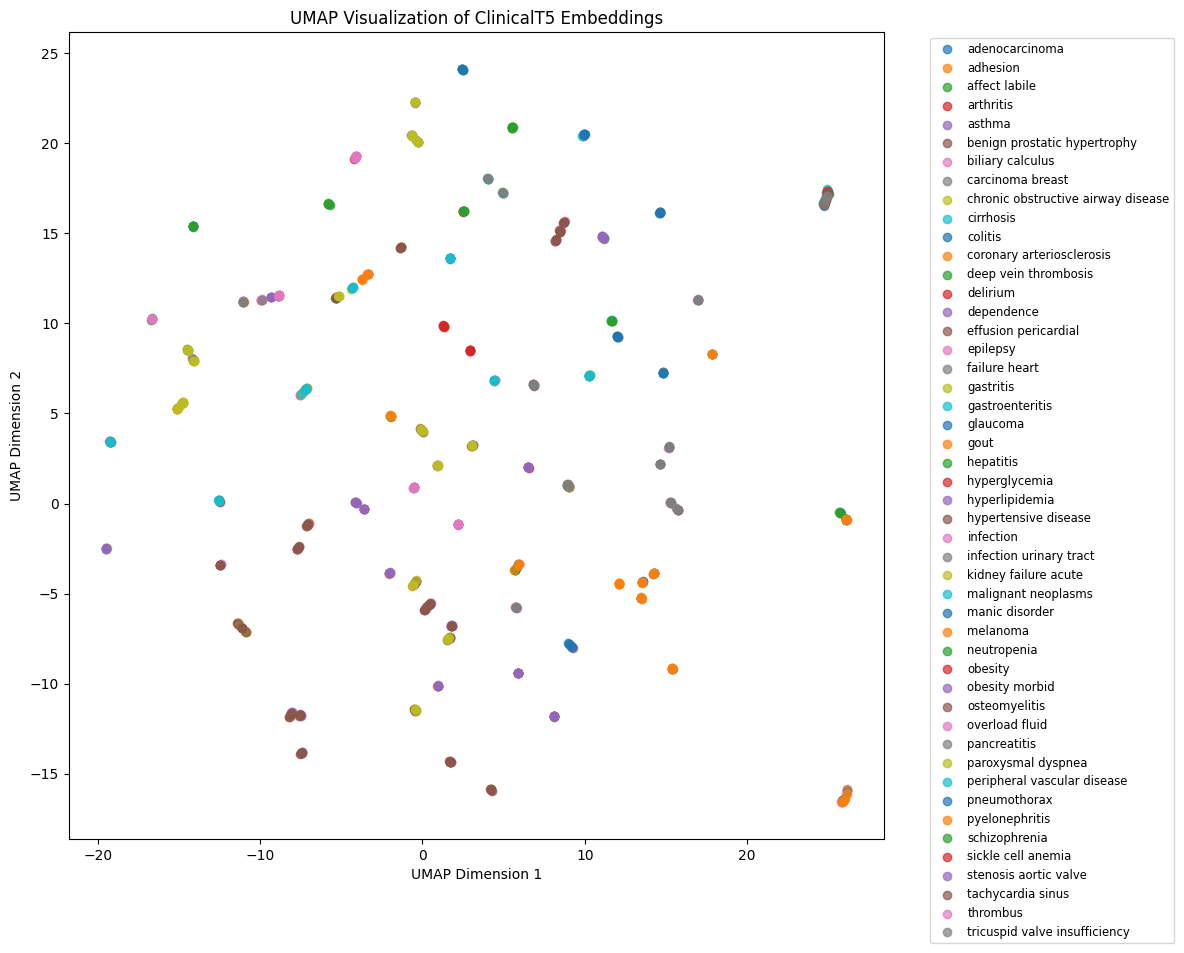

In [13]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

# Generate test embeddings (ensure this is executed before using UMAP)
# test_embeddings should already be generated using your generate_embeddings function.
test_labels = torch.tensor(test_data['disease_label'].values, device=device)

# Convert test labels to NumPy for easier handling
labels = test_labels.cpu().numpy()  # Ensure this is defined and matches the test dataset

# Reduce dimensions using UMAP
print("Reducing dimensions using UMAP...")
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_model.fit_transform(test_embeddings)

# Map numeric labels to disease names
disease_names = label_encoder.inverse_transform(labels)  # Map numeric labels to actual disease names

# Plot the 2D representation
plt.figure(figsize=(12, 10))
unique_labels = np.unique(disease_names)

for disease in unique_labels:
    indices = np.where(disease_names == disease)
    plt.scatter(
        reduced_embeddings[indices, 0], reduced_embeddings[indices, 1],
        label=disease, alpha=0.7
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title("UMAP Visualization of ClinicalT5 Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()


# Naive Bayes

In [14]:
# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_embeddings, train_data['disease_label']) # Change 'encoded_labels' to 'disease_label'

# Validate the Model
val_preds = nb_model.predict(val_embeddings)
val_report = classification_report(val_data['disease_label'], val_preds, target_names=label_encoder.classes_, output_dict=True) # Change val_labels to val_data['disease_label']
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = nb_model.predict(test_embeddings)
test_report = classification_report(test_data['disease_label'], test_preds, target_names=label_encoder.classes_, output_dict=True) # Change test_labels to test_data['disease_label']
print("Test Report:")
print(pd.DataFrame(test_report))

Validation Report:
           adenocarcinoma  adhesion  affect labile  arthritis     asthma  \
precision        0.500000  1.000000            0.0   0.227273   0.428571   
recall           1.000000  0.500000            0.0   0.625000   1.000000   
f1-score         0.666667  0.666667            0.0   0.333333   0.600000   
support         12.000000  8.000000            4.0   8.000000  12.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                           0.0          0.500000          0.454545   
recall                              0.0          0.083333          0.625000   
f1-score                            0.0          0.142857          0.526316   
support                             4.0         48.000000          8.000000   

           chronic obstructive airway disease  cirrhosis  ...  pyelonephritis  \
precision                            0.500000   0.500000  ...        0.384615   
recall                               0.200

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [15]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM + ML/clinicalT5-nb-o-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM + ML/clinicalT5-nb-o-class.csv


# Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest on Embeddings
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_embeddings, train_data['disease_label'])

# Validate the Model
val_preds = rf_model.predict(val_embeddings)
val_report = classification_report(val_data['disease_label'], val_preds, target_names=label_encoder.classes_, output_dict=True) # Make sure val_labels is defined and contains the validation labels
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = rf_model.predict(test_embeddings)
test_report = classification_report(test_data['disease_label'], test_preds, target_names=label_encoder.classes_, output_dict=True) # Make sure test_labels is defined and contains the test labels
print("Test Report:")
print(pd.DataFrame(test_report))


Validation Report:
           adenocarcinoma  adhesion  affect labile  arthritis     asthma  \
precision        0.461538       0.0            0.0   0.666667   0.444444   
recall           0.500000       0.0            0.0   0.500000   0.333333   
f1-score         0.480000       0.0            0.0   0.571429   0.380952   
support         12.000000       8.0            4.0   8.000000  12.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                           0.0          0.526316          0.533333   
recall                              0.0          0.208333          1.000000   
f1-score                            0.0          0.298507          0.695652   
support                             4.0         48.000000          8.000000   

           chronic obstructive airway disease  cirrhosis  ...  pyelonephritis  \
precision                            0.416667   0.500000  ...        0.424242   
recall                               0.750

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [17]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM + ML/clinicalT5-rf-o-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM + ML/clinicalT5-rf-o-class.csv


# Support Vector Classifier

In [18]:
# Train Support Vector Classifier (SVC) on Embeddings
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(train_embeddings, train_data['disease_label'])

# Validate the Model
val_preds = svc_model.predict(val_embeddings)
val_report = classification_report(val_data['disease_label'], val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = svc_model.predict(test_embeddings)
test_report = classification_report(test_data['disease_label'], test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Report:
           adenocarcinoma  adhesion  affect labile  arthritis     asthma  \
precision        0.500000       0.0            0.0   0.428571   0.571429   
recall           1.000000       0.0            0.0   0.750000   0.666667   
f1-score         0.666667       0.0            0.0   0.545455   0.615385   
support         12.000000       8.0            4.0   8.000000  12.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                           0.0          0.382979               0.0   
recall                              0.0          0.375000               0.0   
f1-score                            0.0          0.378947               0.0   
support                             4.0         48.000000               8.0   

           chronic obstructive airway disease  cirrhosis  ...  pyelonephritis  \
precision                            0.428571   0.500000  ...        0.468750   
recall                               0.450

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM + ML/clinicalT5-svc-o-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/overlapped/LLM + ML/clinicalT5-svc-o-class.csv
